In [1]:
from k_means_constrained import KMeansConstrained
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import split,nearest_points
from newton_multidimention import Optimize_Drone_Position_Euclidean
import mpldatacursor
import networkx as nx

background = mpimg.imread('./maps/map.png')
plt.style.use('default')

## Creating the delivery Locations

In [2]:
def create_locations(x, y, n, seed_value = None):
    if seed_value != None:
        random.seed(seed_value)

    loc = []
    for _ in range(n):
        loc_x = random.uniform(x[0],y[0])
        loc_y = random.uniform(x[1],y[1])
        loc.append([loc_x,loc_y])
        
    return loc

## Verify delivary locations

In [3]:
def create_polygon(points):
    coords = []

    for pt in points:
        coords.append(pt)

    obs_polygon = Polygon(coords)
    return obs_polygon

In [4]:
def verify_locations(delivery_loc, obstacles):
    obstacle_polygon = []
    answer = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))
    
    for loc in delivery_loc:
        flag = True
        for obs in obstacle_polygon:
            if Point([loc[0],loc[1]]).intersects(obs):
                flag = False
                break
        if flag:
            answer.append(loc)

    return answer

## Visualizing the data

In [5]:
def initial_plot(delivery_loc, obstacles):
    plt.imshow(background, extent=[22.21,34.45,88.45,98.67])
    loc = np.array(delivery_loc)
    plt.scatter(loc[:,0], loc[:,1])
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        plt.fill(x,y,color="red", alpha = 0.3)
    plt.title("Delivery Locations")
    # plt.grid(True)
    plt.xticks(ticks=[24, 26, 28, 30, 32, 34], labels=[0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
    plt.yticks(ticks=[90, 92, 94, 96, 98], labels=[0.5, 1.0, 1.5, 2.0, 2.5])

    # mpldatacursor.datacursor()
    plt.show()

In [6]:
def clusters_plot(clusters, centroids, obstacles):
    plt.imshow(background, extent=[22.21,34.45,88.45,98.67])
    for i in clusters:
        points = np.array(clusters[i])
        plt.scatter(points[:,0], points[:,1])
    plt.scatter(centroids[:,0], centroids[:,1], marker='^', c="black")
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]
        
        plt.fill(x,y,color="red", alpha = 0.3)

    plt.xticks(ticks=[24, 26, 28, 30, 32, 34], labels=[0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
    plt.yticks(ticks=[90, 92, 94, 96, 98], labels=[0.5, 1.0, 1.5, 2.0, 2.5])
    plt.title("After Clustering")
    plt.show()

In [7]:
def dp_plot(clusters, centroids, dp, obstacles):
    plt.imshow(background, extent=[22.21,34.45,88.45,98.67])
    for i in clusters:
        points = np.array(clusters[i])
        plt.scatter(points[:,0], points[:,1])
    plt.scatter(centroids[:,0], centroids[:,1], marker='^', c="black")
    plt.scatter(dp[0], dp[1], marker='+',s=200, c="red")
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        plt.fill(x,y,color="red", alpha = 0.3)

    plt.xticks(ticks=[24, 26, 28, 30, 32, 34], labels=[0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
    plt.yticks(ticks=[90, 92, 94, 96, 98], labels=[0.5, 1.0, 1.5, 2.0, 2.5])
    plt.title("After DP Creation")
    plt.show()

In [8]:
def final_plot(delivery_loc,clusters, dp, obstacles, title=None):
    plt.imshow(background, extent=[22.21,34.45,88.45,98.67])
    colors = ['blue', 'green', 'orange', 'purple', 'brown']

    deliveries = np.array(delivery_loc)
    plt.scatter(deliveries[:,0], deliveries[:,1])

    for i in clusters:
        pts = np.array(clusters[i])

        for j in range(len(pts)-1):
            pt_1 = pts[j]
            pt_2 = pts[j+1]

            plt.plot([pt_1[0], pt_2[0]], [pt_1[1], pt_2[1]], c=colors[i % len(colors)])

    plt.scatter(dp[0], dp[1], c="red", marker='X',s=200)
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        plt.fill(x,y,color="red", alpha = 0.3)

    plt.xticks(ticks=[24, 26, 28, 30, 32, 34], labels=[0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
    plt.yticks(ticks=[90, 92, 94, 96, 98], labels=[0.5, 1.0, 1.5, 2.0, 2.5])
    if title != None:
        plt.title(title)
    else:
        plt.title("Final Result")
    # plt.show()

## KMeans Clustering

In [9]:
def KMeans(delivery_loc, n, k):
    n_cluster = n//k if n%k == 0 else n//k + 1

    model = KMeansConstrained(n_clusters=n_cluster, size_min=1, size_max=k)
    model.fit_predict(np.array(delivery_loc))

    labels = model.labels_
    clusters = {label:[] for label in range(n_cluster)}

    for i in range(len(delivery_loc)):
        clusters[labels[i]].append(delivery_loc[i])

    return model.cluster_centers_, clusters

## Calculate DP

In [10]:
def calculate_dp(centroids):
    x = [i for i,j in centroids]
    y = [j for i,j in centroids]

    loc_x = np.mean(x)
    loc_y = np.mean(y)

    return [loc_x, loc_y]

## Traveling Salesman Problem

In [11]:
def calculate_distance(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.sqrt(np.sum((point1 - point2)**2))

In [12]:
def total_distance(clusters):
    total = 0
    for i in clusters:
        pts = clusters[i]
        for j in range(len(pts)-1):
            total += calculate_distance(pts[j], pts[j+1])
    
    return total

In [13]:
from shapely.ops import split

In [14]:
def line_intersect(line, obstacle):
    parts = split(obstacle, line)

    count = len([geoms for geoms in parts.geoms])

    return count != 1

In [15]:
def is_obstacle_free(line, obstacles):
    for obs in obstacles:
        if line_intersect(line,obs):
            return False
    return True

In [16]:
import math

def find_inter_point(point_a, point_b, obstacles):
    route_line = LineString([point_a, point_b])
    obstacle_polygons = obstacles
    target_obs = None

    # Find all intersections with obstacles (including edges)
    intersections = []
    for obstacle in obstacle_polygons:
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(route_line.intersection(line))
            if target_obs == None and len(intersections)>0:
                target_obs = obstacle

    # If no intersections found, return None
    if not intersections:
        return None

    # Choose the intersection with the smallest sum of distances to A and B
    inter_x = sum(inter.x for inter in intersections)/len(intersections)
    inter_y = sum(inter.y for inter in intersections)/len(intersections)
    nearest_inter = Point(inter_x, inter_y)

    interval = 0.001
    increment = 0.001
    limit = 1.0

    while interval < limit:
        # Check if there's a clear path along either side of the obstacle
        left_side = LineString([point_a, Point(nearest_inter.x - interval, nearest_inter.y)])
        right_side = LineString([point_a, Point(nearest_inter.x + interval, nearest_inter.y)])
        up_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y + interval)])
        down_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y - interval)])

        # check if left_side is obstacle free
        if is_obstacle_free(left_side, obstacle_polygons):
            left_to_B = LineString([[nearest_inter.x - interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_1 = True
            for obs in obstacle_polygons:
                if(left_to_B.intersects(obs)):
                    flag_1 = False
                    break
            if flag_1:
                return [nearest_inter.x - interval, nearest_inter.y]
        # check if right_side is obstacle free
        if is_obstacle_free(right_side, obstacle_polygons):
            right_to_B = LineString([[nearest_inter.x + interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_2 = True
            for obs in obstacle_polygons:
                if(right_to_B.intersects(obs)):
                    flag_2 = False
                    break
            if flag_2:
                return [nearest_inter.x + interval, nearest_inter.y]
        # check if up_side is obstacle free
        if is_obstacle_free(up_side, obstacle_polygons):
            up_to_B = LineString([[nearest_inter.x, nearest_inter.y + interval],[point_b[0],point_b[1]]])
            flag_3 = True
            for obs in obstacle_polygons:
                if(up_to_B.intersects(obs)):
                    flag_3 = False
                    break
            if flag_3:
                return [nearest_inter.x, nearest_inter.y + interval]
        # check if down_side is obstacle free
        if is_obstacle_free(down_side, obstacle_polygons):
            down_to_B = LineString([[nearest_inter.x, nearest_inter.y - interval],[point_b[0],point_b[1]]])
            flag_4 = True
            for obs in obstacle_polygons:
                if(down_to_B.intersects(obs)):
                    flag_4 = False
                    break
            if flag_4:
                return [nearest_inter.x, nearest_inter.y - interval]
        interval += increment

    return None

<font color="red">Try</font>

In [17]:
from shapely.affinity import translate

In [18]:
def scale_polygon(polygon, scale_factor = 0.99):
    centroid = polygon.centroid

    # Define the scale factor to reduce the distance
    scale_factor = scale_factor  # You can adjust this value to control the reduction

    # Create a new polygon with reduced distance from the centroid
    new_points = [translate(Point(p), xoff=(centroid.x - p[0]) * (1 - scale_factor), yoff=(centroid.y - p[1]) * (1 - scale_factor)).coords[0] for p in polygon.exterior.coords]
    new_polygon = Polygon(new_points)

    return new_polygon

In [19]:
def relocate_dp(dp, obstacle_polygon):
    near_point = nearest_points(obstacle_polygon.exterior, dp)

    near_point = near_point[0].coords[0]

    return near_point

In [20]:
def varify_dp(dp, obstacles):
    final_dp = None
    cur_dp = Point([dp[0],dp[1]])

    for obs_id, obstacle in obstacles.items():
        obstacle_polygon = create_polygon(obstacle)
        
        if obstacle_polygon.contains(cur_dp):
            final_dp = list(obstacle_polygon.exterior.coords)
            break
    
    return [dp] if final_dp == None else final_dp

In [21]:
def create_shortest_path(point_1, point_2, obstacle):
    intersections = obstacle.exterior.coords

    # Create a graph
    G = nx.Graph()

    # Add nodes for each point in the space
    G.add_node(tuple(point_1))

    for inter_point in intersections:
        G.add_node(tuple(inter_point))
    
    G.add_node(tuple(point_2))

    # Add edges between adjacent points
    for cur in G.nodes():
        for next in G.nodes():
            if cur == next:
                continue
            line = LineString([cur, next])
            if not line_intersect(line, obstacle):
                G.add_edge(cur, next)

    # Find the shortest path using A*
    start = tuple(point_1)
    goal = tuple(point_2)
    path = nx.astar_path(G, start, goal, heuristic=calculate_distance)

    # graphical representation
    # pos = {node: node for node in G.nodes()}
    # nx.draw(G, pos, node_color='lightgray', with_labels=True)
    # nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color='green')
    # nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color='red')
    # nx.draw_networkx_edges(G, pos, edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)], edge_color='blue', width=2)
    # plt.title('Path Planning with Obstacle Avoidance')
    # plt.show()

    return path

In [22]:
def create_path(source, destination, obstacles):
    line = LineString([source, destination])
    obstacle_free_path = True

    # Check for obstacle intersection
    for obstacle in obstacles:
        if line_intersect(line, obstacle):
            obstacle_free_path = False
            # Recursively find path around the obstacle
            path_around_obstacle = create_shortest_path(source, destination, obstacle)
            # Concatenate the paths
            path = []
            for i in range(len(path_around_obstacle) - 1):
                path.extend(create_path(path_around_obstacle[i], path_around_obstacle[i + 1], obstacles))
            return path

    # Base case: no obstacle in the line
    if obstacle_free_path:
        return [source, destination]

    return []

In [23]:
def check_obstacle_in_line(point_a, point_b, obstacles):
  line = LineString([point_a, point_b])

  for obstacle in obstacles:
    if line.intersects(obstacle):
      intermediate_point = create_shortest_path(point_a, point_b, obstacles.copy())
      distance = 0

      for pts in range(len(intermediate_point)-1):
        distance += calculate_distance(intermediate_point[pts], intermediate_point[pts + 1])

      return distance, intermediate_point

  return calculate_distance(point_a, point_b), None

In [24]:
def create_distance_matrix(points,obstacles,dp=None):
    matrix = {}
    inter_matrix = {}
    obstacle_polygon = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))

    if dp != None:
        points.append(dp)
    for src in points:
        for dest in points:
            src_point = tuple(src)
            dest_point = tuple(dest)
            # distance,inter = check_obstacle_in_line(src_point, dest_point, obstacle_polygon)
            path = create_path(src_point, dest_point, obstacle_polygon)
            distance = 0
            for pts in range(len(path)-1):
                distance += calculate_distance(path[pts], path[pts + 1])
            matrix[(src_point, dest_point)] = distance
            if len(path) > 2:
                inter_matrix[(src_point, dest_point)] = path
    
    return matrix, inter_matrix

In [25]:
from itertools import permutations

def tsp_brut(cluster, dp, distance_matrix, inter_point_matrix):
    paths = list(permutations(cluster))
    distance_list = []

    # work start
    for cur in paths:
        path = list(cur)
        path.append(dp)
        path.insert(0, dp)

        # distance calculation
        distance = 0
        for loc in range (len(path)-1):
            distance += distance_matrix[(tuple(path[loc]), tuple(path[loc + 1]))]
        distance_list.append(distance)

    # getting the minimum distance and path
    min_path = list(paths[np.argmin(distance_list)])
    min_path.append(dp)
    min_path.insert(0,dp)
    min_dist = distance_list[np.argmin(distance_list)]

    #insert intermediate points
    ans_route = []
    for loc in range(len(min_path)-1):
        ans_route.append(min_path[loc])
        if inter_point_matrix.get((tuple(min_path[loc]), tuple(min_path[loc + 1]))):
            intermediate_points =  inter_point_matrix[(tuple(min_path[loc]), tuple(min_path[loc + 1]))]
            for i in range(1,len(intermediate_points)-1):
                ans_route.append(intermediate_points[i])
    ans_route.append(dp)

    print("Optimal path",min_path,"optimal distance",min_dist)

    return ans_route
    # work end

In [26]:
def tsp_crysto(cluster, dp, obstacles, distance_matrix, inter_point_matrix):
    # distance_matrix, inter_point_matrix = create_distance_matrix(cluster, obstacles, dp)
    
    path = cluster
    path.append(dp)
    path.insert(0, dp)

    G = nx.Graph()

    for pt in path:
        G.add_node(tuple(pt))

    for i in range(len(path)-1):
        for j in range(i+1,len(path)):
            G.add_edge(tuple(path[i]),tuple(path[j]), weight = distance_matrix[(tuple(path[i]), tuple(path[j]))])

    path = nx.approximation.traveling_salesman.christofides(G, weight='weight')

    #insert intermediate points
    ans_route = []
    for loc in range(len(path)-1):
        ans_route.append(path[loc])
        if inter_point_matrix.get((tuple(path[loc]), tuple(path[loc + 1]))):
            intermediate_points =  inter_point_matrix[(tuple(path[loc]), tuple(path[loc + 1]))]
            for i in range(1,len(intermediate_points)-1):
                ans_route.append(intermediate_points[i])
    ans_route.append(dp)

    return ans_route

In [27]:
def tsp_greedy(cluster, opt_dp, distance_matrix, inter_point_matrix):
    cluster.insert(0, opt_dp)
    unvisited = cluster.copy()
    tour = [opt_dp]
    unvisited.remove(opt_dp)

    while unvisited:
        nearest_point = min(unvisited, key=lambda x: distance_matrix[(tuple(tour[-1]), tuple(x))])
        tour.append(nearest_point)
        unvisited.remove(nearest_point)

    # Return to the starting point to complete the cycle
    tour.append(opt_dp)

    #insert intermediate points
    ans_route = []
    for loc in range(len(tour)-1):
        ans_route.append(tour[loc])
        if inter_point_matrix.get((tuple(tour[loc]), tuple(tour[loc + 1]))):
            intermediate_points =  inter_point_matrix[(tuple(tour[loc]), tuple(tour[loc + 1]))]
            for i in range(1,len(intermediate_points)-1):
                ans_route.append(intermediate_points[i])
    ans_route.append(opt_dp)

    print("Final route ",ans_route)
    
    return ans_route

In [28]:
def minimum_span_tree(cluster, obstacles):
    distance_matrix, inter_point_matrix = create_distance_matrix(cluster, obstacles)
    paths = list(permutations(cluster))
    distance_list = []

    # work start
    for cur in paths:
        path = list(cur)

        # distance calculation
        distance = 0
        for loc in range (len(path)-1):
            distance += distance_matrix[(tuple(path[loc]), tuple(path[loc + 1]))]
        distance_list.append(distance)

    # getting the minimum distance and path
    min_path = list(paths[np.argmin(distance_list)])
    min_dist = distance_list[np.argmin(distance_list)]

    #insert intermediate points
    ans_route = []
    for loc in range(len(min_path)-1):
        ans_route.append(min_path[loc])
        if inter_point_matrix.get((tuple(min_path[loc]), tuple(min_path[loc + 1]))):
            intermediate_points =  inter_point_matrix[(tuple(min_path[loc]), tuple(min_path[loc + 1]))]
            for i in range(1,len(intermediate_points)-1):
                ans_route.append(intermediate_points[i])
    ans_route.append(min_path[-1])

    print("Optimal path",min_path,"optimal distance",min_dist)

    return ans_route
    

In [29]:
def merge_dp(cluster, entry_exit_dp, obstacles):
    obstacle_polygon = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))

    path_1 = create_shortest_path(entry_exit_dp, cluster[0], obstacle_polygon)
    path_2 = create_shortest_path(cluster[-1],entry_exit_dp, obstacle_polygon)
    
    new_cluster = path_1 + cluster + path_2

    return new_cluster

In [30]:
def create_matrix(clusters, dp, obstacles):
    distance_matrix = dict()
    inter_point_matrix = dict()

    G = nx.Graph()

    G.add_node(tuple(dp))
    for cls_id, cluster in clusters.items():
        for point in cluster:
            G.add_node(tuple(point))

    for obs_id, obs in obstacles.items():
        for point in obs:
            G.add_node(tuple(point))

    nodes = list(G.nodes())

    obstacle_polygon = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))

    for i in range(0,len(nodes)-1):
        for j in range(i+1,len(nodes)):
            intersect = False
            for obstacle in obstacle_polygon:
                if line_intersect(LineString([nodes[i],nodes[j]]),obstacle):
                    intersect = True
                    break
            if not intersect:
                G.add_edge(nodes[i],nodes[j], weight = calculate_distance(nodes[i],nodes[j]))

    dijkstra_paths = nx.all_pairs_dijkstra(G)

    for source, (target_distance, target_path) in dijkstra_paths:
        for point, distance in target_distance.items():
            # if (source, point) not in distance_matrix and (point, source) not in distance_matrix:
            distance_matrix[(source, point)] = distance
            inter_point_matrix[(source, point)] = target_path[point]

    return distance_matrix, inter_point_matrix

In [31]:
def create_entry_exit_list(paths) :
    newton_list = []

    for path_id, path in paths.items():
        newton_list.append(tuple(path[1]))
        newton_list.append(tuple(path[-2]))

    return newton_list

In [32]:
def point_on_obstacle(obstacles, point):
    obstacle_polygon = [create_polygon(obs) for obs_id, obs in obstacles.items()]
    target_point = Point([point[0], point[1]])

    for obstacle in obstacle_polygon:
        if obstacle.contains(target_point):
            return obstacle
        
    return None

In [33]:
def geometric_median(points, obstacles, eps=1e-5):
    # Initial guess for the geometric median
    guess = np.mean(points, axis=0)
    
    while True:
        # Calculate distances from current guess to all points
        distances = np.linalg.norm(points - guess, axis=1)
        
        # Avoid division by zero
        if np.sum(distances) == 0:
            return guess
        
        # Calculate weights as inverse distances
        weights = 1 / distances
        
        # Calculate weighted average
        new_guess = np.sum(points * weights[:, np.newaxis], axis=0) / np.sum(weights)
        
        # Check for convergence
        if np.linalg.norm(new_guess - guess) < eps:
            return new_guess
        
        # check if new_guess on obstacle
        if point_on_obstacle(obstacles, new_guess) != None:
            return new_guess
        
        print("next dp :", new_guess)
        guess = new_guess

## Main

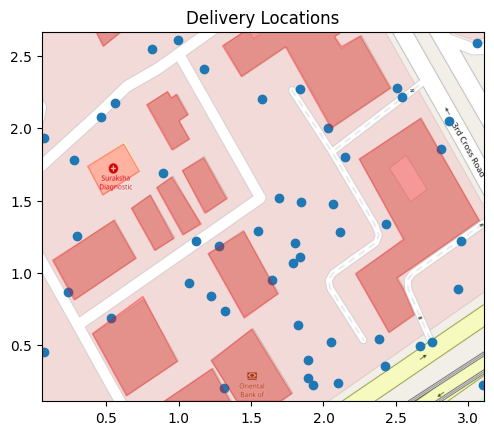

In [34]:
# n = random.randint(20,50)
n = 50
k = 8
seed_value = 10

# creating the boundary
x = [22.21, 88.45]
y = [34.45, 98.67]
delivery_loc = create_locations(x, y, n, seed_value)

# obstacles
obstacles = {
    0 : [[27.81, 90.75],[28.74, 91.42],[27.80, 93.15], [26.81, 92.53], [27.81, 90.75]],
    1 : [[23.11, 91.25], [24.81, 92.40], [24.21, 93.45], [22.51, 92.35],[23.11, 91.25]],
    2 : [[24.55, 88.60],[25.96, 89.55],[25.01, 91.35],[23.61, 90.32],[24.55, 88.60]],
    3 : [[25.60, 88.45], [27.42, 88.45],[26.92, 89.35],[25.60, 88.45]],
    4 : [[27.61, 88.45], [28.81, 88.45],[29.12, 88.66],[28.02, 90.45],[26.90, 89.57],[27.61, 88.45]],
    5 : [[25.33, 92.62], [25.86, 92.95], [25.21, 94.15], [24.69, 93.78], [25.33, 92.63]],
    6 : [[26.11, 93.05], [26.62, 93.35], [25.81, 94.65], [25.39, 94.35], [26.11, 93.05]],
    7 : [[26.72, 93.65], [27.32, 94.05], [26.69, 95.18], [26.10, 94.83], [26.72, 93.65]],
    8 : [[25.81, 95.40],[26.29, 95.70],[26.01, 96.20],[26.25, 96.37],[25.93, 96.94],[25.80, 96.84], [25.69, 97.01],[25.11, 96.65],[25.81, 95.40]],
    9 : [[23.90, 94.15], [24.91, 94.81], [24.48, 95.57],[23.48, 94.95],[23.90, 94.15]],
    10 : [[23.71, 98.67], [23.91, 98.26], [24.41, 98.67],[23.71, 98.67]],
    11 : [[31.81, 90.35], [32.51, 90.85], [32.21, 91.55], [32.03, 91.85], [34.31, 93.45], [32.69, 96.27],[30.99, 95.15], [32.21, 92.93],[30.89, 91.97],[31.81, 90.35]],
    12 : [[30.21, 96.00],[31.85, 97.11], [31.02, 98.55], [30.50, 98.26], [30.31, 98.53], [30.51, 98.67],[27.81, 98.67], [27.21, 98.28], [27.73, 97.43],[28.95, 98.25],[30.21, 96.00]]
}

delivery_loc = verify_locations(delivery_loc, obstacles)
extra_loc = []
while (len(extra_loc)!=n-len(delivery_loc)):
    extra_loc = create_locations(x, y, n-len(delivery_loc))
    extra_loc = verify_locations(extra_loc, obstacles)
delivery_loc.extend(extra_loc)

# Visualize the data
initial_plot(delivery_loc, obstacles)

In [35]:
print(len(delivery_loc))

50


{0: [[29.20396775900454, 92.83324613877967], [28.58299296199268, 91.7998381347778], [26.880857267650004, 91.34857818700664], [29.15296223680464, 92.27406663738547], [26.4642721761428, 92.89274181072312], [29.344071359759273, 92.44179854563427], [28.200086066226397, 93.16592970577956], [27.119829732043367, 92.74684936025746]], 1: [[22.259634964498908, 89.81919922644215], [24.124567561061856, 90.74233545997134], [26.269484405058467, 91.71450548991265], [23.188282396823404, 93.02913156373039], [22.950299037071336, 91.46771893056898]], 2: [[30.47156972893186, 93.11881436381589], [30.604944582209043, 95.21406939093504], [29.364845802591628, 97.07637391410464], [28.28842682306655, 96.80978487447084], [30.2625850904115, 93.90220377837133], [29.369605003853007, 93.95517723488453], [28.76676673652271, 94.07332301069702], [30.127317212745275, 96.00675004472753]], 3: [[34.40785758868293, 88.90536622864343], [33.72786780188501, 91.54523494393712], [32.676739067068866, 89.97981273940772], [31.70227

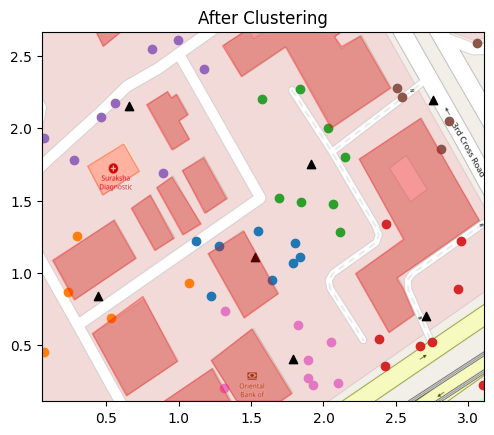

In [36]:
# Cluster the data and get the labels and centroids
centroids, clusters = KMeans(delivery_loc, n, k)

print(clusters)

# Visualize the data
clusters_plot(clusters, centroids, obstacles)

In [37]:
cluster_1 = clusters.copy()

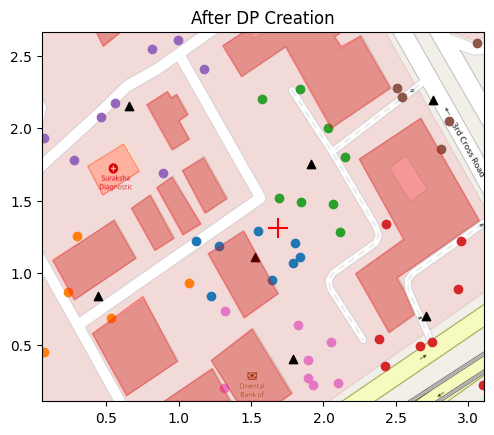

In [38]:
# Calculate DP
initial_dp = calculate_dp(centroids)

# Visualize the data
dp_plot(clusters, centroids, initial_dp, obstacles)

In [39]:
def initial_tsp(cluster, dp, method=None):
    
    if method == "christofides":
        path = cluster
        path.append(dp)
        path.insert(0, dp)

        G = nx.Graph()

        for pt in path:
            G.add_node(tuple(pt))

        for i in range(len(path)-1):
            for j in range(i+1,len(path)):
                G.add_edge(tuple(path[i]),tuple(path[j]), weight = calculate_distance(path[i], path[j]))

        path = nx.approximation.traveling_salesman.christofides(G, weight='weight')
    
    elif method == 'brut_force':
        path = list(permutations(cluster))
        cost = []
        # add dp at the start and end
        for i in range(len(path)):
            path[i] = list(path[i])
            path[i].append(dp)
            path[i].insert(0, dp)

            # Calculate distance
            points = path[i]
            sum = 0

            for j in range(len(points)-1):
                sum += calculate_distance(points[j], points[j+1])
            cost.append(sum)

        idx = np.argmin(cost)
        path = path[idx]

        print("Optimal path :",path)

    else:
        path = cluster
        path.append(dp)
        path.insert(0, dp)

    return path

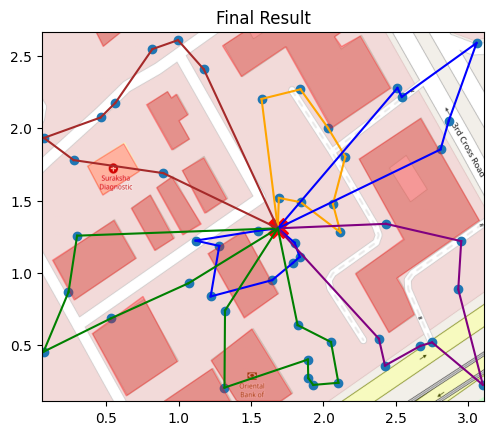

In [40]:
for i in cluster_1:
    cluster_1[i] = initial_tsp(cluster_1[i].copy(), initial_dp,"christofides")

final_plot(delivery_loc,cluster_1, initial_dp, obstacles)

In [41]:
initial_distance = total_distance(cluster_1)
print("Initial distance, without considering obstacles :",initial_distance)

Initial distance, without considering obstacles : 101.18780117526445


#### Cluster -> Greedy

In [42]:
# change dp location if dp on obstacle
DP = varify_dp(initial_dp, obstacles)

In [43]:
# Shortest path calculation in each cluster
min_distance = float('inf')
brutforce_path = None
brutforce_dp = None

brut_distance_matrix = dict()
brut_intermediate_point_matrix = dict()

for each_dp in DP:
    cluster_2 = clusters.copy()
    distance_matrix, intermediate_point_matrix = create_matrix(cluster_2.copy(), each_dp, obstacles)
    for i in clusters:
        cluster_2[i] = tsp_greedy(cluster_2[i].copy(), each_dp, distance_matrix, intermediate_point_matrix)
        # cluster_2[i] = tsp_brut(cluster_2[i].copy(), each_dp, distance_matrix, intermediate_point_matrix)
    
    distance = total_distance(cluster_2)
    if distance < min_distance:
        min_distance = distance
        brutforce_path = cluster_2.copy()
        brutforce_dp = each_dp
        brut_distance_matrix = distance_matrix
        brut_intermediate_point_matrix = intermediate_point_matrix


Final route  [[28.738846280850407, 93.23281808633597], [28.200086066226397, 93.16592970577956], [29.20396775900454, 92.83324613877967], [29.344071359759273, 92.44179854563427], [29.15296223680464, 92.27406663738547], [28.58299296199268, 91.7998381347778], (27.8, 93.15), [27.119829732043367, 92.74684936025746], [26.4642721761428, 92.89274181072312], [26.880857267650004, 91.34857818700664], (26.81, 92.53), (27.8, 93.15), [28.738846280850407, 93.23281808633597]]
Final route  [[28.738846280850407, 93.23281808633597], (27.8, 93.15), (26.81, 92.53), [26.269484405058467, 91.71450548991265], (25.01, 91.35), [24.124567561061856, 90.74233545997134], (23.11, 91.25), [22.950299037071336, 91.46771893056898], [22.259634964498908, 89.81919922644215], (22.51, 92.35), [23.188282396823404, 93.02913156373039], (24.21, 93.45), (25.33, 92.62), (27.8, 93.15), [28.738846280850407, 93.23281808633597]]
Final route  [[28.738846280850407, 93.23281808633597], [28.76676673652271, 94.07332301069702], [29.3696050038

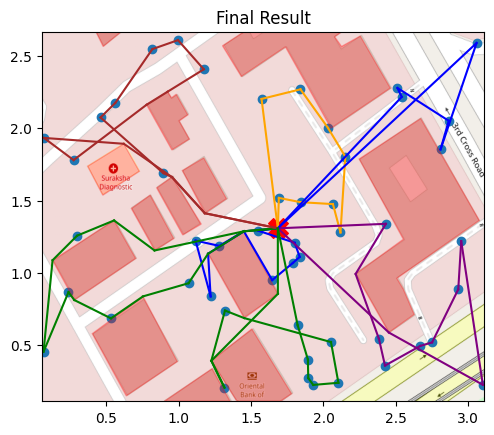

In [44]:
# Final Visualization
final_plot(delivery_loc,brutforce_path, brutforce_dp, obstacles)

#### Cluster_2 -> Crystofieds

In [45]:
min_distance = float('inf')
christo_path = None
christo_dp = None

cluster_3 = clusters.copy()

for i in cluster_3:
    cluster_3[i] = tsp_crysto(cluster_3[i].copy(), brutforce_dp, obstacles, brut_distance_matrix, brut_intermediate_point_matrix)
    
distance = total_distance(cluster_3)
if distance < min_distance:
    min_distance = distance
    christo_path = cluster_3.copy()
    christo_dp = brutforce_dp

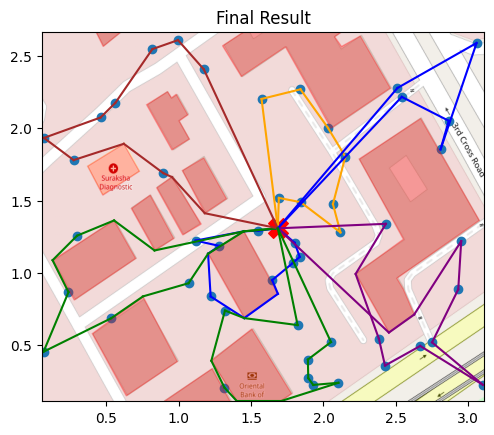

In [46]:
final_plot(delivery_loc,christo_path, christo_dp, obstacles)

## <font color="orange">DP Pruning</font>

In [47]:
## list of entry exit points creation
newton_points = create_entry_exit_list(christo_path)

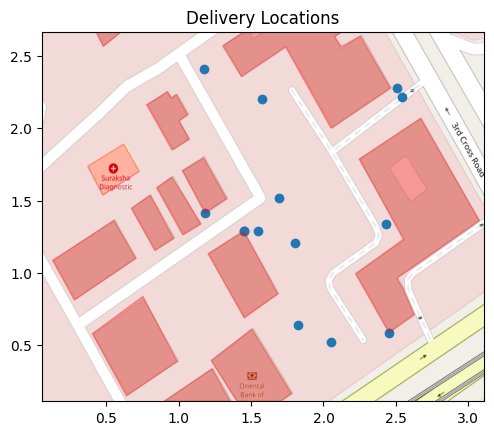

In [48]:
initial_plot(newton_points, obstacles)

In [49]:
## feed the list into geometric median to get optimized dp
geometric_dp = geometric_median(newton_points.copy(), obstacles)

print("Enhanced dp =",geometric_dp)
print("Previous dp =",brutforce_dp)

next dp : [28.98053214 93.56851034]
next dp : [28.84647369 93.50133332]
next dp : [28.78875122 93.46938133]
next dp : [28.76043626 93.45252219]
next dp : [28.74552166 93.44348414]
next dp : [28.73736902 93.43862043]
next dp : [28.73282799 93.43599119]
next dp : [28.73027512 93.4345615 ]
next dp : [28.72883375 93.43377925]
next dp : [28.72801849 93.43334874]
next dp : [28.7275571  93.43311061]
next dp : [28.72729598 93.43297833]
next dp : [28.72714825 93.43290459]
next dp : [28.72706469 93.43286338]
next dp : [28.72701745 93.43284029]
next dp : [28.72699074 93.43282734]
next dp : [28.72697565 93.43282006]
Enhanced dp = [28.72696713 93.43281596]
Previous dp = [28.738846280850407, 93.23281808633597]


In [50]:
# repeat this with geometric dp

min_distance = float('inf')
opt_christo_path = None
opt_christo_dp = None

cluster_4 = clusters.copy()
opt_distance_matrix, opt_intermediate_point_matrix = create_matrix(cluster_4.copy(), geometric_dp, obstacles)

for i in cluster_4:
    cluster_4[i] = tsp_crysto(cluster_4[i].copy(), geometric_dp, obstacles, opt_distance_matrix, opt_intermediate_point_matrix)
    
distance = total_distance(cluster_4)
if distance < min_distance:
    min_distance = distance
    opt_christo_path = cluster_3.copy()
    opt_christo_dp = brutforce_dp

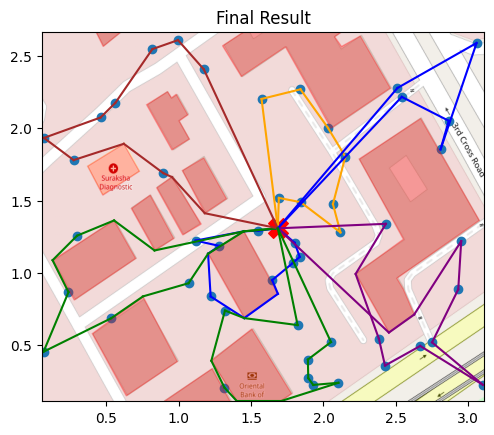

In [51]:
final_plot(delivery_loc,opt_christo_path, opt_christo_dp, obstacles)

## Calculate Total DIstance

*Total distance in manhattan cluster*

In [52]:
new_distance = total_distance(cluster_2)
print("Distance considering obstacles and brute force method :",new_distance)

Distance considering obstacles and brute force method : 122.33318839051377


In [53]:
christofides_distance = total_distance(cluster_3)
print("Distance considering obstacles and christofides method :",christofides_distance)

Distance considering obstacles and christofides method : 113.55813329002977


In [54]:
opt_christofides_distance = total_distance(cluster_4)

print("Distance considering obstacles and optimized christofides method :",opt_christofides_distance)

Distance considering obstacles and optimized christofides method : 113.44763370630831


In [55]:
print("Without obstacle distance \t: ",initial_distance)
print("Greedy Approach distance \t: ",new_distance)
print("christofides distance \t\t: ",christofides_distance)
print("Optimized christofides \t\t: ", opt_christofides_distance)

Without obstacle distance 	:  101.18780117526445
Greedy Approach distance 	:  122.33318839051377
christofides distance 		:  113.55813329002977
Optimized christofides 		:  113.44763370630831


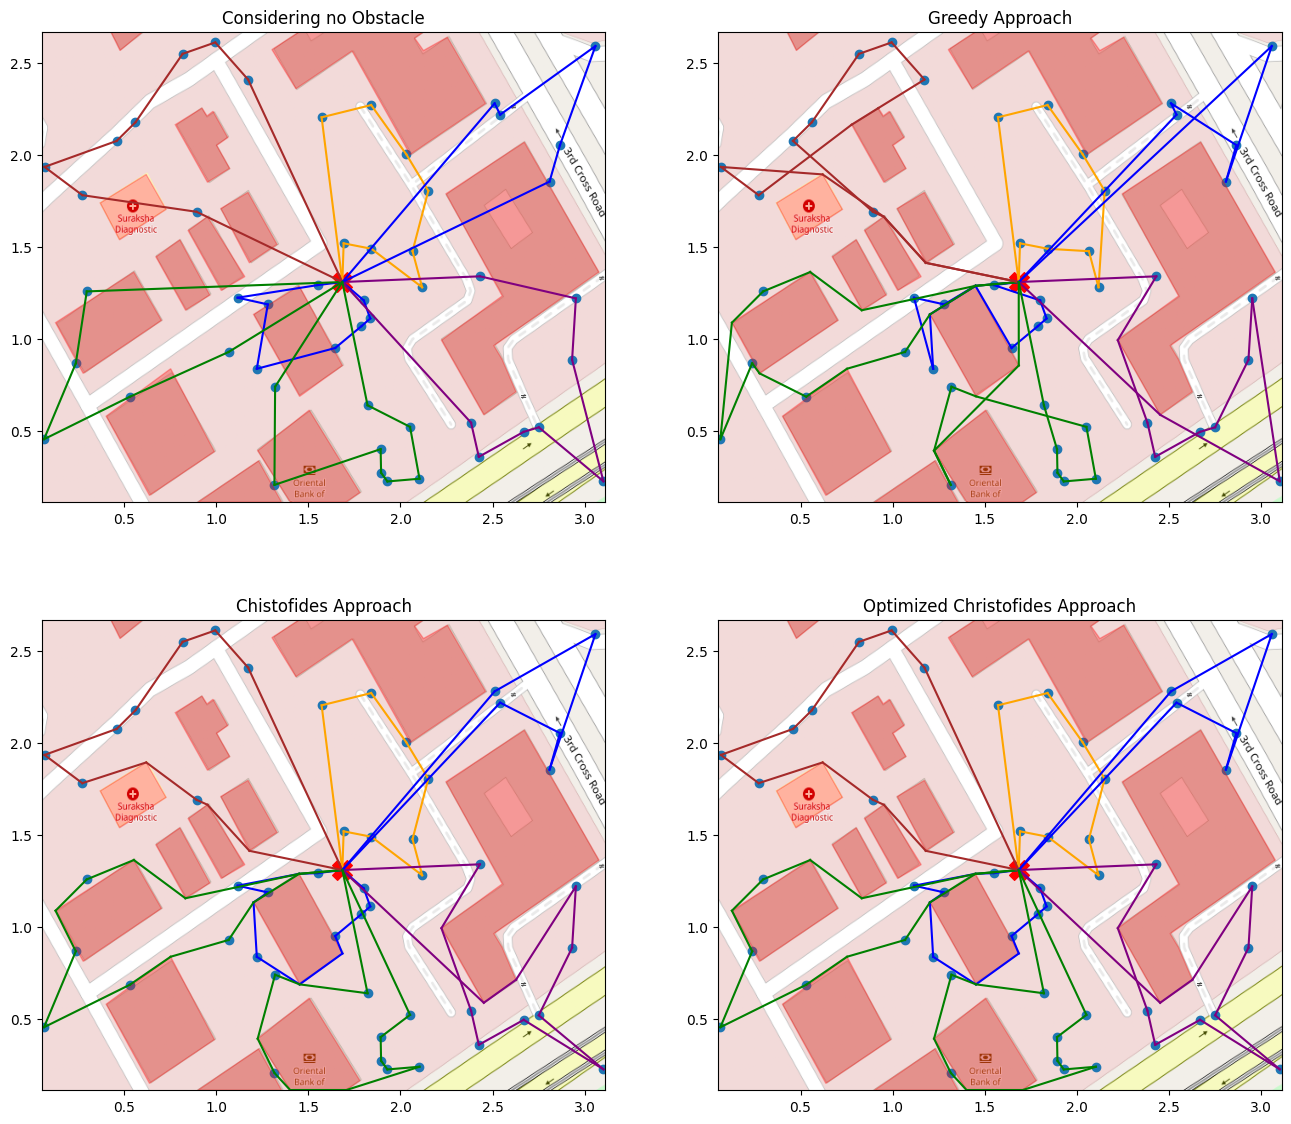

In [56]:
plt.figure(figsize=(16,14))

plt.subplot(2,2,1)
final_plot(delivery_loc,cluster_1, initial_dp, obstacles, title="Considering no Obstacle")
plt.subplot(2,2,2)
final_plot(delivery_loc,brutforce_path, brutforce_dp, obstacles, title = "Greedy Approach")
plt.subplot(2,2,3)
final_plot(delivery_loc,christo_path, christo_dp, obstacles, title = "Chistofides Approach")
plt.subplot(2,2,4)
final_plot(delivery_loc,opt_christo_path, opt_christo_dp, obstacles, title = "Optimized Christofides Approach")

plt.show()

## file handling

In [57]:
# import pandas as pd

# df = pd.read_csv('./drone_performance_on_obstacles.csv')

# new_row = {
#     'delivary_locations':n,
#     'drone_capacity':1,
#     'obstacles':len(obstacles),
#     'obstacle_free_distance':initial_distance,
#     'distance_after_obstacle_avoidance':new_distance
# }

# df.loc[len(df)] = new_row

# df.tail(5)

In [58]:
# try:
#     df.to_csv('./drone_performance_on_obstacles.csv', index=False)
# except:
#     print("Unknown error occurs")

In [59]:
import pandas as pd

df = pd.read_csv('./drone_performance_on_obstacle_capacity_k.csv')

new_row = {
    'delivary_locations':n,
    'drone_capacity':k,
    'obstacles':len(obstacles),
    'obstacle_free_distance':initial_distance,
    'greedy_distance':new_distance,
    'christofides_distance':christofides_distance,
    'optimized_distance':opt_christofides_distance
}

df.loc[len(df)] = new_row

df.tail(5)

,delivary_locations,drone_capacity,obstacles,obstacle_free_distance,greedy_distance,christofides_distance,optimized_distance
12,50,4,13,150.118615,165.661871,161.846112,161.789410
13,50,6,13,119.014320,128.997113,125.548377,125.488534
14,50,8,13,107.753088,122.417404,114.061320,114.246298
15,50,8,13,101.187801,122.333188,113.558133,113.447634
16,50,8,13,101.187801,122.333188,113.558133,113.447634


In [60]:
try:
    df.to_csv('./drone_performance_on_obstacle_capacity_k.csv', index=False)
except:
    print("Unknown error occurs")

## Hold